In [0]:
import tweepy as tw
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import time

In [0]:
# App Auth
#apikey='APIkey'
#apisecretkey='APISecretKey'
#accesstoken='AccessToken'
#accesstokensecret='AccessSecret'

In [0]:
# Initialize API
auth = tw.OAuthHandler(apikey, apisecretkey)
auth.set_access_token(accesstoken, accesstokensecret)
api = tw.API(auth, wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [0]:
# Search terms
search_words = "coronavirus  -filter:retweets", "#COVID-19 -filter:retweets"
date_since = "2020-04-28"
date_until ="2020-05-11"

In [0]:
# Collect tweets
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since,
              result_type="mixed",
              until=date_until).items(10)

In [0]:
# Iterate tweets
try:
	tweet_details = [[tweet.text,tweet.user.screen_name,tweet.source,tweet.user.location,tweet.created_at] for tweet in tweets]
except tweepy.TweepError as e:
 	print(e.reason)
time.sleep(60)

In [0]:
#Store tweet in a dataframe
tweet_df = pd.DataFrame(data=tweet_details, columns=['text','user','source', "location", "created_at"])

In [8]:
# NLP imports
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

#python imports
import string
import re

# preprocessor data sources and instances
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))
lm = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
#define functions to clean tweet
def clean_tweets(text):
     # remove mentions, hashtags and punctuation
    text = re.sub(r'RT|@[a-zA-Z0-9_]+|:|#[a-zA-Z0-9_]+|[0-9]+|,|\'|\"|\`|…', '', text)
    text = re.sub(r'  ', '', text.strip())
    #remove Http sign
    text = re.sub("https?://[A-Za-z0-9./]*","",text)
    text = re.sub("\n","",text)
    text = re.sub("RT","",text)
    return text
def clean_tweets(source):
    source = re.sub("Twitter for","",source)
    source = re.sub("Twitter","",source)
    return source

In [0]:
tweet_df['text']=tweet_df['text'].apply(lambda x: clean_tweets(x))
tweet_df['source']=tweet_df['source'].apply(lambda x: clean_tweets(x))

In [0]:
#Lemmatization
sentences_processed = []
for sentence in tweet_df['text']:
    # Obtain word tokens
    tokenized_words = word_tokenize(sentence)
    # Remove stop words
    filtered_words = list(filter(lambda x: x not in stop_words, tokenized_words))
    # Lemmatization
    lemmatized_words = list(map(lm.lemmatize, filtered_words))
    sentences_processed.append(" ".join(lemmatized_words))

In [0]:
data = pd.DataFrame(data={'text': sentences_processed})

In [13]:
#update dataframe
tweet_df['text'] = data['text']
tweet_df.head(10)

,text,user,source,location,created_at
0,An LA nurse faced choice : rush COVID patient ...,skarlamangla,iPhone,"Los Angeles, California",2020-05-10 17:43:22
1,And . 72 Wisconsinites tested positive coronav...,briantylercohen,Web App,Los Angeles,2020-05-09 23:18:28
2,Millions Indians forced download country ’ cor...,techreview,Echobox,"Cambridge, MA",2020-05-09 12:26:47
3,Belgian Dr ’ experience Not flu # coronavirus ...,hazelbagend,iPhone,Lfiklgjrylîlefkgkgofg,2020-05-10 23:59:59
4,RT @ skarlamangla : An LA nurse faced choice :...,vdeviance,Web App,"Fort Worth, TX",2020-05-10 23:59:58
5,"RT @ qiaocollective : The mayor Belleville , N...",NiaSymone92,Web App,"Virginia, USA",2020-05-10 23:59:57
6,RT @ JenniferJJacobs : BREAKING scoop : Vice P...,mythtriss,Web App,"NC, USA",2020-05-10 23:59:56
7,RT @ WendyFry_ : A hero : A nurse without N95 ...,JonathanABailey,Web App,Under the Rainbow,2020-05-10 23:59:56
8,RT @ GovHowardDean : Govs Arizona Florida ille...,justicesky0507,Android,"Cleveland, OH",2020-05-10 23:59:56
9,RT @ danahull : Scathing editorial @ sacbee_ne...,CaptnAtheist,Android,"Salem, Oregon",2020-05-10 23:59:56


Load combined tweet csv fetched over the last 10 days

In [21]:
combined_tweets = pd.read_csv('tweets_combined.csv', error_bad_lines=False);
combined_tweets.head(5)

,Unnamed: 0,text,user,source,location,created_at
0,0,"The Mexican government reporting hundred , pos...",nytimes,SocialFlow,New York City,5/8/2020 12:00
1,1,Coronavirus detected semen ; jury 's whether v...,latimeshealth,dlvr.it,"Los Angeles, CA",5/7/2020 19:58
2,2,Here ’ reassuring news . LIFEBUOY WORLD 'S FIR...,BeingSalmanKhan,Android,MUMBAI,5/8/2020 12:17
3,3,RT @ FOX5Vegas : BREAKING : Las Vegas legend R...,damesmith,iPhone,Kansas City,5/9/2020 1:30
4,4,RT @ TMZ : Roy Horn Siegfried Roy Has Died 75 ...,goose68ca,Android,"Guelph, Ontario",5/9/2020 1:30


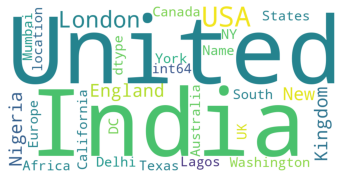

In [22]:
text = combined_tweets.location.value_counts().head(20)
wordcloud = WordCloud(background_color='white',mode="RGB", width=1000 , height=500).generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

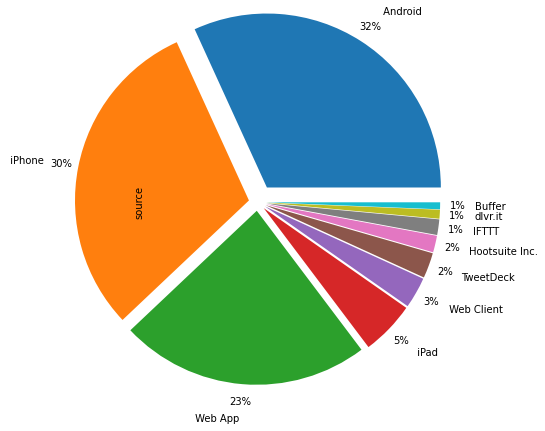

In [23]:
#Top 10 tweet sources
tweet_source = combined_tweets.source.value_counts()

explode = (0.2, 0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1,0.1,0.1) 
df2 = tweet_source[:10].plot(kind = 'pie', explode=explode, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, radius=2)

In [24]:
#filter tweet by location

uk_tweets = combined_tweets[combined_tweets["location"].str.contains("United Kingdom|London|London, England| Uk", na=False)]
uk_tweets.head(5)

,Unnamed: 0,text,user,source,location,created_at
15,15,RT @ RaifaRafiq : No matter Boris say easing r...,HafsahCadeey,iPhone,"London, England",5/7/2020 19:58
133,133,RT @ RCOT_CYPF : RT @ theRCOT : Are occupation...,RCOT_Louise,iPhone,London,5/7/2020 19:57
167,167,RT @ pitchfork : UK rapper Ty died battle coro...,Owlfaces,iPhone,"Hackney, London",5/7/2020 19:57
260,260,RT @ pitchfork : UK rapper Ty died battle coro...,TownCalledVinny,iPhone,"London, England",5/7/2020 19:56
289,289,RT @ NHSVolResponder : If test positive please...,Tilly5001,Android,"England, United Kingdom",5/7/2020 19:56


Implementing NMF




In [0]:
import sklearn;
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer;
from sklearn.decomposition import NMF

In [0]:
# NMF is able to use tf-idf
no_features = 2000
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(uk_tweets['text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [0]:
#Initialize the number of Topics we need to cluster:
num_topics = 20;

In [0]:
# Run NMF
nmf = NMF(n_components=num_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)


In [0]:
#display topics
def display_topics(model, feature_names, no_top_words):
 for topic_idx, topic in enumerate(model.components_):
  print ("Topic", topic_idx)
  print (" ".join([feature_names[i]
    for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [31]:
no_top_words = 15
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0
http coronavirus new interesting home lockdown business latest visit information read week check covid19 stay
Topic 1
refused china request investigation origin skynews repeated representative organisation world covid19 health rt covid invited
Topic 2
19 covid rt pandemic test world http country crisis vaccine health coronavirus amp life care
Topic 3
evidence trump wuhan say lab came wo efzp8gppet reveal virus skynews seen coronavirus donald originated
Topic 4
pandemic estimated household fallen million citizensadvice people government coronavirus rt amid tmz files bankruptcy syirqkq1c7
Topic 5
death ons local area 232 occurred deprivation 17 march 90 analysis april published 19 covid
Topic 6
people black time rate white hospital caribbean killing england ftdata likely die new ons fvhd5m0u8s
Topic 7
emergency come today disease asthmauk worldasthmaday year affect global health covid19 rt study support impact
Topic 8
experience mean tony johnmcdonnellmp lloyd nhs minute amp acco

Sentiment Analysis of topic

In [32]:
#load nlkt 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [0]:
analyser = SentimentIntensityAnalyzer()

In [0]:
#filter tweets related to health
health_tweets = uk_tweets[uk_tweets["text"].str.contains("health", na=False)]

In [35]:
#loop through tweet and assign sentiment score
i=0

#empty list to hold computed 'compound' VADER scores
compval1 = [ ]


while (i<len(health_tweets)):

    k = analyser.polarity_scores(health_tweets.iloc[i]['text'])
    compval1.append(k['compound'])
    
    i = i+1

len(compval1)

57

In [36]:
#display score
health_tweets['VADER score'] = compval1
health_tweets.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,text,user,source,location,created_at,VADER score
2026,2026,RT @ Reuters : COVID-19 expose gaping hole hea...,Angie_RejoinEU,iPad,London,5/7/2020 19:44,-0.1531
2328,2328,RT @ Dmozaffarian : We ’ created perfect envir...,orangebobevil,Android,United Kingdom,5/7/2020 19:42,0.7906
2577,2577,RT @ NHSuk : ✔️ Exercise daily keep mind body ...,homes4haringey,Web App,"Haringey, North London, UK",5/7/2020 19:40,0.4019
2958,2958,RT @ ClubZTeens : SHAMEFUL : Israel providing ...,BestWebEnglish,Web App,London / Madrid,5/7/2020 19:37,-0.4824
4755,4755,RT @ Dmozaffarian : We ’ created perfect envir...,AlanType2,Web App,"London, England",5/7/2020 19:25,0.7906


In [0]:
#Assigning score sentiment categories
i = 0

predicted_value = [ ] #empty series to hold our predicted values

while(i<len(health_tweets)):
    if ((health_tweets.iloc[i]['VADER score'] >= 0.7)):
        predicted_value.append('positive')
        i = i+1
    elif ((health_tweets.iloc[i]['VADER score'] > 0) & (health_tweets.iloc[i]['VADER score'] < 0.7)):
        predicted_value.append('neutral')
        i = i+1
    elif ((health_tweets.iloc[i]['VADER score'] <= 0)):
        predicted_value.append('negative')
        i = i+1

In [38]:
health_tweets['sentiment'] = predicted_value
health_tweets.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,text,user,source,location,created_at,VADER score,sentiment
2026,2026,RT @ Reuters : COVID-19 expose gaping hole hea...,Angie_RejoinEU,iPad,London,5/7/2020 19:44,-0.1531,negative
2328,2328,RT @ Dmozaffarian : We ’ created perfect envir...,orangebobevil,Android,United Kingdom,5/7/2020 19:42,0.7906,positive
2577,2577,RT @ NHSuk : ✔️ Exercise daily keep mind body ...,homes4haringey,Web App,"Haringey, North London, UK",5/7/2020 19:40,0.4019,neutral
2958,2958,RT @ ClubZTeens : SHAMEFUL : Israel providing ...,BestWebEnglish,Web App,London / Madrid,5/7/2020 19:37,-0.4824,negative
4755,4755,RT @ Dmozaffarian : We ’ created perfect envir...,AlanType2,Web App,"London, England",5/7/2020 19:25,0.7906,positive


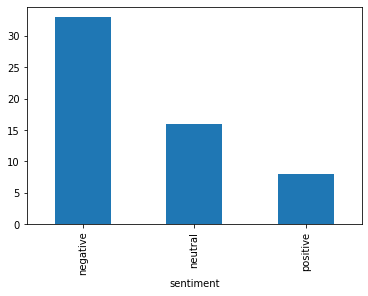

In [39]:
#Plot bar chart showing the sentiment levels
health_tweets.groupby('sentiment').size().plot(kind='bar')

In [0]:
#word cloud of most frequenct words
words = ' '.join(health_tweets['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
stopwords = set(STOPWORDS)
stopwords.add("Covid")
stopwords.add("Dmozaffarian")
stopwords.add("coronavirus")
stopwords.add("co")
stopwords.add("amp")
stopwords.add("Today")
stopwords.add("COVID19")
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='white',
                      max_words=100,
                      width=1500,
                      height=1250
                     ).generate(cleaned_word)

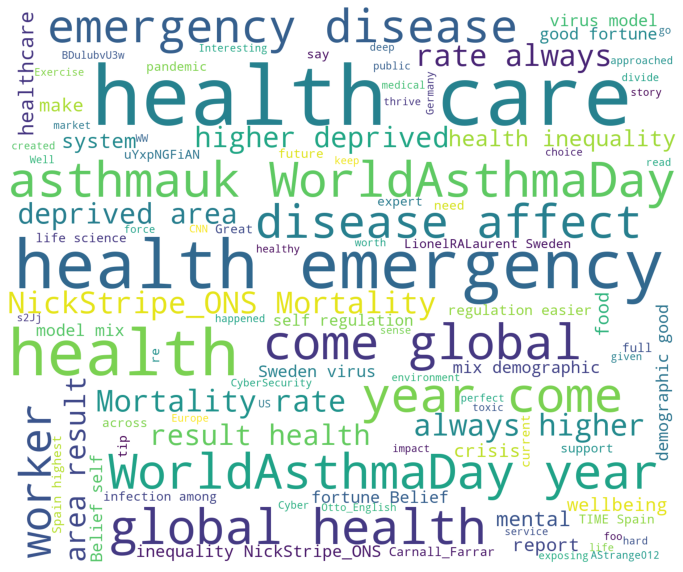

In [41]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()